In [79]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.style.use("ggplot")

from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Input, SimpleRNN, Embedding, Dense, GRU, \
                          Dropout, BatchNormalization, LSTM

print(tf.keras.__version__)
print(tf.__version__)

2.2.4-tf
2.0.0


In [80]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}


In [81]:
df_google = pd.read_csv("google_trend_data/google_trend_region.csv")
df_google = df_google.drop(['iso', 'country', 'geoCode'], axis=1)
df_google['date'] = pd.to_datetime(df_google['date'])
df_google.rename(columns={'geoName':'state'}, inplace=True)
df_google['state'] = df_google['state'].map(lambda x: us_state_abbrev[x])
df_google.head()

,date,state,coronavirus,covid,dry cough,fever,shortness of breath,face mask
0,2020-01-01,AL,0,0,0,25,43,3
1,2020-01-02,AL,0,0,0,35,20,2
2,2020-01-03,AL,0,0,0,32,0,0
3,2020-01-04,AL,0,0,35,35,0,2
4,2020-01-05,AL,0,0,18,23,43,2


In [82]:
df_weather = pd.read_csv("weather_data_0411.csv", index_col=0)
df_weather.rename(columns={'Date':'date', 'Province_State':'state'}, inplace=True)
df_weather['date'] = pd.to_datetime(df_weather['date'])
df_weather['state'] = df_weather['state'].map(lambda x: us_state_abbrev[x])
df_weather.head()

,date,Country_Region,state,ConfirmedCases,Fatalities,Lat,Long,temp,min,max,stp,slp,dewp,rh,ah,wdsp,prcp,fog
19197,2020-01-22,US,AL,0.0,0.0,32.3182,-86.9023,33.7,21.6,48.9,999.9,NaN,NaN,NaN,NaN,2.5,0.00,0
19198,2020-01-23,US,AL,0.0,0.0,32.3182,-86.9023,41.5,37.9,46.2,999.9,NaN,NaN,NaN,NaN,2.8,0.00,0
19199,2020-01-24,US,AL,0.0,0.0,32.3182,-86.9023,51.6,45.9,61.0,999.9,NaN,NaN,NaN,NaN,4.9,0.87,0
19200,2020-01-25,US,AL,0.0,0.0,32.3182,-86.9023,43.1,29.5,57.0,999.9,NaN,NaN,NaN,NaN,5.4,0.02,0
19201,2020-01-26,US,AL,0.0,0.0,32.3182,-86.9023,42.5,31.6,53.8,999.9,NaN,NaN,NaN,NaN,2.0,0.00,0


In [83]:
df_weather = df_weather[['date','state','temp', 'stp', 'wdsp', 'prcp','fog']].reset_index(drop=True)
df_weather.head()

,date,state,temp,stp,wdsp,prcp,fog
0,2020-01-22,AL,33.7,999.9,2.5,0.00,0
1,2020-01-23,AL,41.5,999.9,2.8,0.00,0
2,2020-01-24,AL,51.6,999.9,4.9,0.87,0
3,2020-01-25,AL,43.1,999.9,5.4,0.02,0
4,2020-01-26,AL,42.5,999.9,2.0,0.00,0


In [84]:
df_tweeter = pd.read_csv('twitter_0501.csv',index_col=0)
df_tweeter['date'] = pd.to_datetime(df_tweeter['date'])
df_tweeter.head()

,date,Chinawords,Italywords,USwords,Outbreakwords,twitter_number
0,2020-01-21,5,0,4,0,224
1,2020-01-22,199,0,57,45,28520
2,2020-01-23,1436,3,107,524,186460
3,2020-01-24,3207,0,487,1054,660769
4,2020-01-25,3558,2,448,1320,998717


In [85]:
confirm_df = pd.read_csv("testnum_data_0506.csv")
confirm_df = confirm_df[['date', 'state', 'positive', 'death', 'total']]
confirm_df = confirm_df.fillna(0)
confirm_df['date'] = pd.to_datetime(confirm_df['date'], format="%Y%m%d")
confirm_df.head()

,date,state,positive,death,total
0,2020-05-06,AK,372.0,10.0,23655
1,2020-05-06,AL,8581.0,340.0,109516
2,2020-05-06,AR,3568.0,85.0,59003
3,2020-05-06,AS,0.0,0.0,83
4,2020-05-06,AZ,9707.0,426.0,91737


In [86]:
df_all = confirm_df.merge(df_weather, on=['date', 'state']).merge(df_google, on=['date', 'state'])#.merge(df_tweeter, on='date')

In [87]:
#df_all.to_csv("dataset_all.csv")
df_all = df_all.sort_values(by='date', ascending=True)
df_all.to_csv("dataset_all_notweet.csv")

In [37]:
df_train = df_all[df_all['date'] < '2020-04-01']
df_test = df_all[df_all['date'] >= '2020-04-01']

### Prepare RNN Dataset

In [38]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = [], []
    for i in range(sequence.shape[0]):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
            # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix, ], sequence[end_ix][0]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

def create_dataset(df, n_step):
    x_data, y_data = [], []
    for state, state_df in df.groupby("state"):
        state_df = state_df.sort_values(by='date', ascending=True)
        seq = state_df.drop(["state", 'date'], axis=1).to_numpy()
        x, y = split_sequence(seq, n_step)
        x_data.append(x)
        y_data.append(y)

    x_data, y_data = np.concatenate(x_data), np.concatenate(y_data)
    return x_data, y_data

In [39]:
x_train, y_train = create_dataset(df_train, 3)
x_test, y_test = create_dataset(df_test, 3)

In [40]:
x_train.shape

(1240, 3, 14)

In [41]:
x_test.shape

(408, 3, 14)

### RNN Model

In [77]:
# design network
model = Sequential()
model.add(GRU(10, input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(Dense(1,  activation='relu'))
opt = tf.keras.optimizers.RMSprop(learning_rate=0.1)
model.compile(loss='mse', optimizer=opt)

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 10)                780       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 791
Trainable params: 791
Non-trainable params: 0
_________________________________________________________________
None


In [78]:
# fit network
history = model.fit(x_train, y_train, epochs=600, batch_size=2, validation_data=(x_test, y_test), verbose=2, shuffle=False)


Train on 1240 samples, validate on 408 samples
Epoch 1/600
1240/1240 - 3s - loss: 20350475.5364 - val_loss: 516042333.2866
Epoch 2/600
1240/1240 - 2s - loss: 20183156.5288 - val_loss: 514556472.7986
Epoch 3/600
1240/1240 - 1s - loss: 20084165.9700 - val_loss: 513671334.1405
Epoch 4/600
1240/1240 - 1s - loss: 20028654.9039 - val_loss: 513123323.9654
Epoch 5/600
1240/1240 - 2s - loss: 19995475.6330 - val_loss: 512774192.8540
Epoch 6/600
1240/1240 - 2s - loss: 19974818.4951 - val_loss: 512547516.3775
Epoch 7/600
1240/1240 - 2s - loss: 19961617.6400 - val_loss: 512398565.3813
Epoch 8/600
1240/1240 - 2s - loss: 19953036.6768 - val_loss: 512299922.2711
Epoch 9/600
1240/1240 - 2s - loss: 19947394.0120 - val_loss: 512234237.0253
Epoch 10/600
1240/1240 - 2s - loss: 19943656.6264 - val_loss: 512190386.2249
Epoch 11/600
1240/1240 - 2s - loss: 19941167.5606 - val_loss: 512160988.3838
Epoch 12/600
1240/1240 - 2s - loss: 19939506.4734 - val_loss: 512141276.5623
Epoch 13/600
1240/1240 - 2s - loss: 19

Epoch 107/600
1240/1240 - 2s - loss: 19936121.9632 - val_loss: 512100989.2160
Epoch 108/600
1240/1240 - 2s - loss: 19936121.9615 - val_loss: 512100989.2160
Epoch 109/600
1240/1240 - 2s - loss: 19936121.9626 - val_loss: 512100989.2160
Epoch 110/600
1240/1240 - 2s - loss: 19936121.9666 - val_loss: 512100989.2160
Epoch 111/600
1240/1240 - 2s - loss: 19936121.9626 - val_loss: 512100989.2160
Epoch 112/600
1240/1240 - 2s - loss: 19936121.9607 - val_loss: 512100988.9939
Epoch 113/600
1240/1240 - 2s - loss: 19936121.9635 - val_loss: 512100989.2160
Epoch 114/600
1240/1240 - 2s - loss: 19936121.9603 - val_loss: 512100989.2787
Epoch 115/600
1240/1240 - 2s - loss: 19936121.9666 - val_loss: 512100989.2160
Epoch 116/600
1240/1240 - 2s - loss: 19936121.9625 - val_loss: 512100989.2160
Epoch 117/600
1240/1240 - 2s - loss: 19936121.9598 - val_loss: 512100989.2160
Epoch 118/600
1240/1240 - 2s - loss: 19936121.9635 - val_loss: 512100988.9939
Epoch 119/600
1240/1240 - 2s - loss: 19936121.9621 - val_loss: 5

1240/1240 - 1s - loss: 19936121.9607 - val_loss: 512100988.9939
Epoch 213/600
1240/1240 - 1s - loss: 19936121.9635 - val_loss: 512100989.2160
Epoch 214/600
1240/1240 - 1s - loss: 19936121.9603 - val_loss: 512100989.2787
Epoch 215/600
1240/1240 - 1s - loss: 19936121.9666 - val_loss: 512100989.2160
Epoch 216/600
1240/1240 - 1s - loss: 19936121.9625 - val_loss: 512100989.2160
Epoch 217/600
1240/1240 - 1s - loss: 19936121.9598 - val_loss: 512100989.2160
Epoch 218/600
1240/1240 - 1s - loss: 19936121.9635 - val_loss: 512100988.9939
Epoch 219/600
1240/1240 - 1s - loss: 19936121.9621 - val_loss: 512100989.2787
Epoch 220/600
1240/1240 - 1s - loss: 19936121.9608 - val_loss: 512100989.2787
Epoch 221/600
1240/1240 - 1s - loss: 19936121.9613 - val_loss: 512100989.2160
Epoch 222/600
1240/1240 - 1s - loss: 19936121.9622 - val_loss: 512100989.2787
Epoch 223/600
1240/1240 - 1s - loss: 19936121.9610 - val_loss: 512100989.2160
Epoch 224/600
1240/1240 - 1s - loss: 19936121.9593 - val_loss: 512100989.2160


Epoch 318/600
1240/1240 - 1s - loss: 19936121.9635 - val_loss: 512100988.9939
Epoch 319/600
1240/1240 - 2s - loss: 19936121.9621 - val_loss: 512100989.2787
Epoch 320/600
1240/1240 - 2s - loss: 19936121.9608 - val_loss: 512100989.2787
Epoch 321/600
1240/1240 - 1s - loss: 19936121.9613 - val_loss: 512100989.2160
Epoch 322/600
1240/1240 - 1s - loss: 19936121.9622 - val_loss: 512100989.2787
Epoch 323/600
1240/1240 - 2s - loss: 19936121.9610 - val_loss: 512100989.2160
Epoch 324/600
1240/1240 - 1s - loss: 19936121.9593 - val_loss: 512100989.2160
Epoch 325/600
1240/1240 - 1s - loss: 19936121.9597 - val_loss: 512100989.2160
Epoch 326/600
1240/1240 - 1s - loss: 19936121.9632 - val_loss: 512100989.2160
Epoch 327/600
1240/1240 - 1s - loss: 19936121.9632 - val_loss: 512100989.2160
Epoch 328/600
1240/1240 - 1s - loss: 19936121.9615 - val_loss: 512100989.2160
Epoch 329/600
1240/1240 - 1s - loss: 19936121.9626 - val_loss: 512100989.2160
Epoch 330/600
1240/1240 - 2s - loss: 19936121.9666 - val_loss: 5

1240/1240 - 1s - loss: 19936121.9610 - val_loss: 512100989.2160
Epoch 424/600
1240/1240 - 1s - loss: 19936121.9593 - val_loss: 512100989.2160
Epoch 425/600
1240/1240 - 1s - loss: 19936121.9597 - val_loss: 512100989.2160
Epoch 426/600
1240/1240 - 1s - loss: 19936121.9632 - val_loss: 512100989.2160
Epoch 427/600
1240/1240 - 1s - loss: 19936121.9632 - val_loss: 512100989.2160
Epoch 428/600
1240/1240 - 1s - loss: 19936121.9615 - val_loss: 512100989.2160
Epoch 429/600
1240/1240 - 1s - loss: 19936121.9626 - val_loss: 512100989.2160
Epoch 430/600
1240/1240 - 1s - loss: 19936121.9666 - val_loss: 512100989.2160
Epoch 431/600
1240/1240 - 1s - loss: 19936121.9626 - val_loss: 512100989.2160
Epoch 432/600
1240/1240 - 1s - loss: 19936121.9607 - val_loss: 512100988.9939
Epoch 433/600
1240/1240 - 1s - loss: 19936121.9635 - val_loss: 512100989.2160
Epoch 434/600
1240/1240 - 1s - loss: 19936121.9603 - val_loss: 512100989.2787
Epoch 435/600
1240/1240 - 1s - loss: 19936121.9666 - val_loss: 512100989.2160


Epoch 529/600
1240/1240 - 1s - loss: 19936121.9626 - val_loss: 512100989.2160
Epoch 530/600
1240/1240 - 1s - loss: 19936121.9666 - val_loss: 512100989.2160
Epoch 531/600
1240/1240 - 1s - loss: 19936121.9626 - val_loss: 512100989.2160
Epoch 532/600
1240/1240 - 1s - loss: 19936121.9607 - val_loss: 512100988.9939
Epoch 533/600
1240/1240 - 1s - loss: 19936121.9635 - val_loss: 512100989.2160
Epoch 534/600
1240/1240 - 1s - loss: 19936121.9603 - val_loss: 512100989.2787
Epoch 535/600
1240/1240 - 1s - loss: 19936121.9666 - val_loss: 512100989.2160
Epoch 536/600
1240/1240 - 1s - loss: 19936121.9625 - val_loss: 512100989.2160
Epoch 537/600
1240/1240 - 1s - loss: 19936121.9598 - val_loss: 512100989.2160
Epoch 538/600
1240/1240 - 1s - loss: 19936121.9635 - val_loss: 512100988.9939
Epoch 539/600
1240/1240 - 1s - loss: 19936121.9621 - val_loss: 512100989.2787
Epoch 540/600
1240/1240 - 1s - loss: 19936121.9608 - val_loss: 512100989.2787
Epoch 541/600
1240/1240 - 1s - loss: 19936121.9613 - val_loss: 5

In [44]:
print("Variance of train dataset:", np.var(y_train))
print("Variance of test dataset:", np.var(y_test))

Variance of train dataset: 19629550.522590403
Variance of test dataset: 452590736.1732026


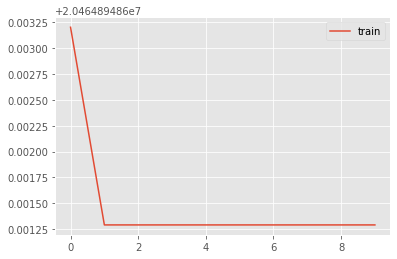

In [45]:
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

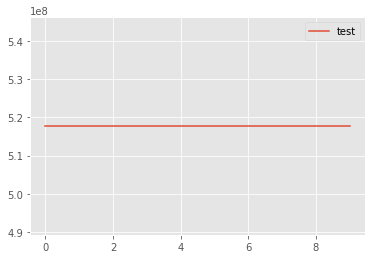

In [46]:
# plot history
#plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [88]:
def plot_state(state):
    x_train_state, y_train_state = create_dataset(df_train[df_train['state']==state], 3)
    x_test_state, y_test_state = create_dataset(df_test[df_test['state']==state], 3)
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].plot(df_train[df_train['state']==state].date[3:], model.predict(x_train_state).squeeze(), label='predict')
    ax[0].plot(df_train[df_train['state']==state].date[3:], y_train_state, label='true')
    ax[1].plot(df_test[df_test['state']==state].date[3:], model.predict(x_test_state).squeeze(), label='predict')
    ax[1].plot(df_test[df_test['state']==state].date[3:], y_test_state, label='true')
    ax[0].legend()
    ax[1].legend()
    ax[0].xtick_lables(rotation=70)
    ax[0].set_title("Train {}, MSE: {}".format(state, mean_squared_error(y_train_state, model.predict(x_train_state).squeeze())))
    ax[1].set_title("Test {}, MSE: {}".format(state, mean_squared_error(y_test_state, model.predict(x_test_state).squeeze())))


AttributeError: 'AxesSubplot' object has no attribute 'xtick_lables'

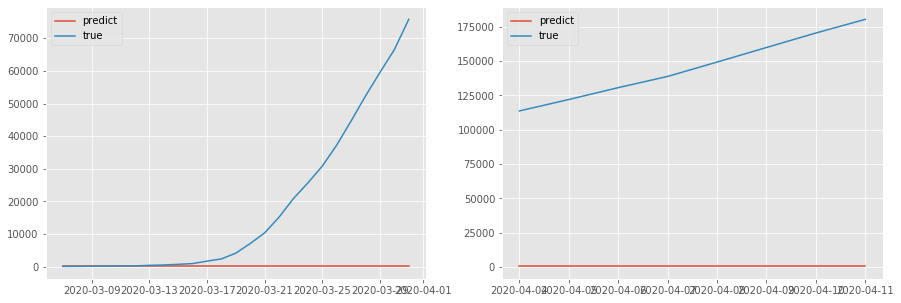

In [89]:
plot_state('NY')